Calculate mult for 64-to-4
inspired from scalability/scalability.ipynb

In [ ]:
loadlevel = 0.05
numlink = 1066 
flowfile = "c2s_64_4_1_0_0_0"
bytespermult = 0
with open(f"/u/az6922/DRing/src/emp/datacentre/flowfiles/{flowfile}",'r') as f:
    lines = f.readlines()
    for line in lines:
        tokens = line.split(',')
        bytespermult += int(tokens[2])
    
bytesperlink = 894784*1500*0.2 # 894784 packets per second, 1500B per packet, 200ms
totalbytes = bytesperlink*numlink # *2 for 2 directions, /2 for 2 hops per flow
usablebytes = totalbytes*loadlevel
mult = usablebytes/bytespermult
print(f"{flowfile}: {mult}")

Decide on what routing to use
inspired from computerouting2/computerouting2.ipynb, testspatial

In [19]:
import sys
import os
import gurobipy as gp
from gurobipy import GRB

homedir = "/u/az6922"

def compute(graphfile,numsw,netpathfile,serverfile,flowfile,numserver):
    # read netpathfile
    netpath = list()
    for i in range(numsw):
        netpath.append(list())
        for j in range(numsw):
            netpath[i].append(list())
    with open(netpathfile,'r') as f:
        lines = f.readlines()
        # produce
        fromsw = 0
        tosw = 0
        for line in lines:
            if "->" not in line:
                tokens = line.split()
                fromsw = int(tokens[0])
                tosw = int(tokens[1])
            else:
                path = [fromsw]
                tokens = line.split()
                for token in tokens:
                    hops = token.split("->")
                    path.append(int(hops[1]))
                netpath[fromsw][tosw].append(path)

        # check
        for line in lines:
            if "->" not in line:
                tokens = line.split()
                fromsw = int(tokens[0])
                tosw = int(tokens[1])
                numpaths = int(tokens[2])
                if len(netpath[fromsw][tosw])!=numpaths:
                    print(f"ERROR: netpath is wrong, fromsw={fromsw}, tosw={tosw}, numpaths from file={numpaths}, numpaths from array={len(netpath[fromsw][tosw])}")

    # read graphfile
    link = list()
    for i in range(numsw):
        link.append(list())
        for j in range(numsw):
            link[i].append(0)
    with open(graphfile,'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.split("->")
            fromsw = int(tokens[0])
            tosw = int(tokens[1])
            link[fromsw][tosw] = 1
            link[tosw][fromsw] = 1

    # read linkfailurefile (if needed)
    # if numfaillink > 0:
    #     with open(linkfailurefile,'r') as f:
    #         lines = f.readlines()
    #         for line in lines:
    #             tokens = line.split()
    #             fromsw = int(tokens[0])
    #             tosw = int(tokens[1])
    #             if link[fromsw][tosw] != 1:
    #                 print(f"ERROR: should have a link from {fromsw} to {tosw} but not")
    #             else:
    #                 link[fromsw][tosw] /= 2

    # read serverfile
    serverdict = dict()
    with open(serverfile,'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.split(',')
            serverdict[int(tokens[0])] = int(tokens[1])

    # read flowfile
    traffic = list()
    for i in range(numsw):
        traffic.append(list())
        for j in range(numsw):
            traffic[i].append(0)
    with open(flowfile,'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.split(",")
            fromsvr = int(tokens[0])
            tosvr = int(tokens[1])
            if fromsvr>=numserver or tosvr>=numserver: continue
            fromsw = serverdict[fromsvr]
            tosw = serverdict[tosvr]
            if fromsw == tosw: continue
            flowbytes = int(tokens[2])
            traffic[fromsw][tosw] += flowbytes


    # precompute
    flowsvialink = list()
    for i in range(numsw):
        flowsvialink.append(list())
        for j in range(numsw):
            flowsvialink[i].append(list())
    for fromsw in range(numsw):
        for tosw in range(numsw):
            if traffic[fromsw][tosw] > 0:
                for pid,path in enumerate(netpath[fromsw][tosw]):
                    fidpidstr = f"{fromsw},{tosw},{pid}"
                    prevhop = fromsw
                    for hop in path[1:]:
                        flowsvialink[prevhop][hop].append(fidpidstr)
                        prevhop = hop

    for fromsw in range(numsw):
        for tosw in range(numsw):
            traffic[fromsw][tosw] /= 100000


    # Create a new model
    model = gp.Model("mcf")

    # Add variables
    maxpid = 0
    for fromsw in range(numsw):
        for tosw in range(numsw):
            maxpid = max(maxpid,len(netpath[fromsw][tosw]))
    vararr = list()
    for fromsw in range(numsw):
        vararr.append(list())
        for tosw in range(numsw):
            vararr[fromsw].append(list())
            for pid in range(maxpid):
                vararr[fromsw][tosw].append(None)
    for fromsw in range(numsw):
        for tosw in range(numsw):
            if traffic[fromsw][tosw] > 0:
                for pid in range(len(netpath[fromsw][tosw])):
                    var = model.addVar(name=f"{fromsw}_{tosw}_{pid}")
                    vararr[fromsw][tosw][pid] = var
    k = model.addVar(name="k")

    # Set objective function
    model.setObjective(k, GRB.MAXIMIZE)

    # Add constraints
    # Constraint 0: for each fid: sum(pid) >= k * traffic[fid.from][fid.to]
    for fromsw in range(numsw):
        for tosw in range(numsw):
            if traffic[fromsw][tosw] > 0:
                varlist = list()
                for pid in range(len(netpath[fromsw][tosw])):
                    varlist.append(vararr[fromsw][tosw][pid])
                model.addConstr(sum(varlist)>=k*traffic[fromsw][tosw],f"c0_{fromsw}_{tosw}")

    # Constraint 1: for each link: sum(fid_pid) <= link[link.from][link.to]
    for linkfrom in range(numsw):
        for linkto in range(numsw):
            flowstrlist = flowsvialink[linkfrom][linkto]
            if len(flowstrlist) > 0:
                varlist = list()
                for flowstr in flowstrlist:
                    tokens = flowstr.split(',')
                    flowfrom = int(tokens[0])
                    flowto = int(tokens[1])
                    pid = int(tokens[2])
                    varlist.append(vararr[flowfrom][flowto][pid])
                model.addConstr(sum(varlist)<=link[linkfrom][linkto],f"c1_{linkfrom}_{linkto}")

    # Constraint 2: for each fid: for each pid: pid = prev_pid
    for fromsw in range(numsw):
        for tosw in range(numsw):
            if traffic[fromsw][tosw] > 0:
                for pid in range(1,len(netpath[fromsw][tosw])):
                    model.addConstr(vararr[fromsw][tosw][pid]-vararr[fromsw][tosw][pid-1]==0,f"c2_{fromsw}_{tosw}_{pid}")

    # Optimize model
    model.setParam('Method',-1)
    model.setParam('Crossover',0)
    model.optimize()
    # modelfile = "/home/annzhou/DRing/src/emp/datacentre/experiments/torbottleneck/model.lp"
    # model.write(modelfile)

    # Print results
    if model.status == GRB.OPTIMAL:
        # print(f"Optimal objective value: {model.objVal}")
        resultfile = f"{homedir}/DRing/src/emp/datacentre/experiments/torbottleneck/whatrouting.txt"
        with open(resultfile,'a') as f:
            f.write(f"{flowfile},{routingname},{k.x}\n")
            # for fromsw in range(numsw):
            #     for tosw in range(numsw):
            #         if traffic[interval][fromsw][tosw] > 0:
            #             for pid in range(len(netpath[fromsw][tosw])):
            #                 var = vararr[fromsw][tosw][pid]
            #                 f.write(f"{var.varName},{var.x}\n")
    else:
        print("No optimal solution found")
    return

In [ ]:
fileprefix = f"{homedir}/DRing/src/emp/datacentre"
graphfile = f"{fileprefix}/graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist"
numsw = 80
numserver = 2988
routingnamearr = ["ecmp","su2","su3"]
serverfile = f"{fileprefix}/serverfiles/dring_2988_80_64"
clist = [64,48,32,16,4]
multlist = [[0,72,100],[0,96,100],[1,44,100],[2,88,100],[11,50,100]]
tseedlist = range(5)

for ic,c in enumerate(clist):
    mult = multlist[ic][0]
    numerator = multlist[ic][1]
    denominator = multlist[ic][2]
    for tseed in tseedlist:
        flowfile = f"{fileprefix}/flowfiles/c2s_{c}_4_{mult}_{numerator}_{denominator}_{tseed}"
        for routingname in routingnamearr:
            netpathfile = f"{fileprefix}/netpathfiles/netpath_{routingname}_dring.txt"
            compute(graphfile,numsw,netpathfile,serverfile,flowfile,numserver)

Generate conffiles

In [21]:
graphname = "dring"
multlist = [[0,72,100],[0,96,100],[1,44,100],[2,88,100],[11,50,100]]
clist = [64,48,32,16,4]
s=4
tseedlist = range(5)
sseed = 1
homedir = "/u/az6922"

conffile = f"{homedir}/DRing/src/emp/datacentre/experiments/torbottleneck/torbottleneck.conf"
makeleafspine = "MAKE"
makedring = "MAKE"
with open(conffile,'w') as f:
    for ic,c in enumerate(clist):
        mult = multlist[ic][0]
        numerator = multlist[ic][1]
        denominator = multlist[ic][2]
        multstr = f"{mult}_{numerator}_{denominator}"
        for tseed in tseedlist:
            flowfilename = f"flowfiles/c2s_{c}_{s}_{multstr}_{tseed}"
            flowfile = f"/u/az6922/DRing/src/emp/datacentre/{flowfilename}"

            routingdict = dict()
            with open(f"{homedir}/DRing/src/emp/datacentre/experiments/torbottleneck/whatrouting.txt",'r') as fr:
                lines = fr.readlines()
                for line in lines:
                    tokens = line.split(',')
                    if tokens[0]==flowfile:
                        routingdict[tokens[1]] = float(tokens[2])
            if max(routingdict.values()) == routingdict["ecmp"]:
                routingname = "ecmp"
                rt1 = "ecmp"
                rt2 = 0
            elif max(routingdict.values()) == routingdict["su2"]:
                routingname = "su2"
                rt1 = "su"
                rt2 = 2
            elif max(routingdict.values()) == routingdict["su3"]:
                routingname = "su3"
                rt1 = "su"
                rt2 = 3
            
            lsqvarfile = f"qvarfiles/qvar_leafspine_0_0_ecmp_64"
            lsnetpathfile = f"netpathfiles/netpath_ecmp_leafspine.txt"
            dringqvarfile = f"qvarfiles/qvar_{graphname}_0_0_{routingname}_c2s_{c}_{s}_{tseed}_{multstr}_2_0_64"
            dringnetpathfile = f"netpathfiles/netpath_{routingname}_{graphname}.txt"
            dringgraphfile = f"graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist"
            dringserverfile = f"serverfiles/dring_2988_80_64"
        
            f.write(f"./run.sh LEAFSPINE {makeleafspine} 80 3072 64 leafspine_tb NEW_FILE null {mult} {numerator} {denominator} 0 0 0 0 0 0 ecmp 0 {flowfilename} null {sseed} {lsnetpathfile} {lsqvarfile} 64 50 150 200 0 0 > m_torbottleneck_leafspine_{c}_{s}_{multstr}_{tseed}.log\n")
            f.write(f"./run.sh RRG {makedring} 80 2988 64 dring_tb NEW_FILE {dringgraphfile} {mult} {numerator} {denominator} 0 0 0 0 0 0 {rt1} {rt2} {flowfilename} {dringserverfile} {sseed} {dringnetpathfile} {dringqvarfile} 64 50 150 200 0 0 > m_torbottleneck_dring_{c}_{s}_{multstr}_{tseed}.log\n")
            makeleafspine = "NOMAKE"
            makedring = "NOMAKE"

generate sumfile & picklefile

In [ ]:
import pickle

homedir = "/u/az6922"
datadict = dict()
conffile = f"{homedir}/DRing/src/emp/datacentre/experiments/torbottleneck/torbottleneck.conf"
sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/torbottleneck/torbottleneck.txt"
with open(conffile,'r') as f:
    with open(sumfile,'a') as sumf:
        lines = f.readlines()
        for line in lines:
            tokens = line.split()
            logfile = tokens[32]
            sizelist = list()
            durationlist = list()
            startlist = list()
            with open(f"{homedir}/DRing/src/emp/datacentre/{logfile}",'r') as logf:
                print(logfile)
                loglines = logf.readlines()
                for logline in loglines:
                    logtokens = logline.split()
                    if logtokens[0] == "FCT":
                        durationlist.append(float(logtokens[2]))
                        sizelist.append(int(logtokens[1]))
                        startlist.append(float(logtokens[3]))
            datadict[logfile] = [durationlist,sizelist,startlist]
            durationlist.sort()
            sumf.write(f"{logfile}\t{sum(durationlist)/len(durationlist)}\t{durationlist[int(len(durationlist)*0.5)]}\t{durationlist[int(len(durationlist)*0.99)]}\t{durationlist[int(len(durationlist)*0.9999)]}\n")

with open(f'{homedir}/DRing/src/emp/datacentre/experiments/torbottleneck/torbottleneck.pickle', 'wb') as handle:
    pickle.dump(datadict, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot

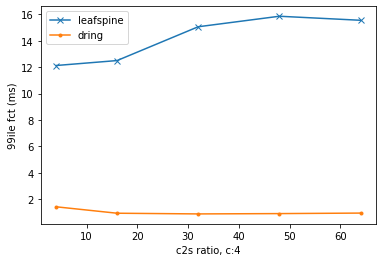

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

homedir = "/u/az6922"
multlist = [[0,72,100],[0,96,100],[1,44,100],[2,88,100],[11,50,100]]
clist = [64,48,32,16,4]
s=4
tseedlist = range(5)
sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/torbottleneck/torbottleneck.txt"

index = 3

ylist_ls = list()
ylist_dring = list()
for ic,c in enumerate(clist):
    mult = multlist[ic][0]
    numerator = multlist[ic][1]
    denominator = multlist[ic][2]
    multstr = f"{mult}_{numerator}_{denominator}"
    fct_over_tseed_ls = list()
    fct_over_tseed_dring = list()
    with open(sumfile,'r') as f:
        lines = f.readlines()
        for tseed in tseedlist:
            logfile = f"m_torbottleneck_leafspine_{c}_{s}_{multstr}_{tseed}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[index])
                    fct_over_tseed_ls.append(n99fct)
        ylist_ls.append(sum(fct_over_tseed_ls)/len(fct_over_tseed_ls))

        for tseed in tseedlist:
            logfile = f"m_torbottleneck_dring_{c}_{s}_{multstr}_{tseed}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[index])
                    fct_over_tseed_dring.append(n99fct)
        ylist_dring.append(sum(fct_over_tseed_dring)/len(fct_over_tseed_dring))
plt.plot(clist,ylist_ls,label="leafspine",marker='x')
plt.plot(clist,ylist_dring,label="dring",marker='.')
plt.legend()
plt.xlabel('c2s ratio, c:4')
plt.ylabel('99ile fct (ms)')
# plt.title(f'{trafficname}, 5 runs')
# plt.ylim(0,20)
# plt.savefig(f"{homedir}/DRing/src/emp/datacentre/experiments/routing/{trafficname}.png", dpi=500)
plt.show()

delete log,run files

In [ ]:
import os

homedir = "/u/az6922"
dringdir = f"{homedir}/DRing/src/emp/datacentre"
for filedir in os.listdir(dringdir):
    if os.path.isfile(os.path.join(dringdir, filedir)):
        tokens = filedir.split("_")
        if tokens[0]=="m" and tokens[1]=="torbottleneck" and tokens[-1].split('.')[-1]=="log":
            print(filedir)
            os.remove(f"{homedir}/DRing/src/emp/datacentre/{filedir}")
        if (tokens[0]=="rrg" or tokens[0]=="leafspine") and tokens[1]=="log":
            print(filedir)
            os.remove(f"{homedir}/DRing/src/emp/datacentre/{filedir}")
        if (tokens[-1]=="run") and ((tokens[0]=="leafspine" and tokens[1]=="leafspine") or (tokens[0]=="rrg" and (tokens[1]=="rrg" or tokens[1]=="dring"))):
            print(filedir)
            os.remove(f"{homedir}/DRing/src/emp/datacentre/{filedir}")